In [1]:
import os
import os.path as osp
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
# from mplfonts import use_font
from optuna.trial import TrialState

# 设置matplotlib字体，使之显示中文
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

/home/luyiyun/miniconda3/envs/tdm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
d_results = {
    # "策略1": "./results/opt_res_m100_one",
    # "策略2": "./results/opt_res_m80_one",
    # "策略3": "./results/opt_res_m50_one",
    # "策略4": "./results/opt_res_m30_one",
    "策略1": "./results/opt_res_m30_one_agespan011_bigpopulation_adj_mortality_fixcecx",
    "策略2": "./results/opt_res_m40_one_agespan011_bigpopulation_adj_mortality_fixcecx",
    "策略3": "./results/opt_res_m50_one_agespan011_bigpopulation_adj_mortality_fixcecx",
    "策略4": "./results/opt_res_m60_one_agespan011_bigpopulation_adj_mortality_fixcecx",
    "策略5": "./results/opt_res_m80_one_agespan011_bigpopulation_adj_mortality_fixcecx",
    "策略6": "./results/opt_res_m100_one_agespan011_bigpopulation_adj_mortality_fixcecx"
}
d_duration = {
    # "策略1": "100",
    # "策略2": "80",
    # "策略3": "50",
    # "策略4": "30",
    "策略1": "30",
    "策略2": "40",
    "策略3": "50",
    "策略4": "60",
    "策略5": "80",
    "策略6": "100",
}

我们先把一些要用的数据载入：

In [3]:
# 跑程序得到的结果
d_values = {}
for k, tar_root in d_results.items():
    t = np.load(osp.join(tar_root, "t.npy"))
    tar_y = np.load(osp.join(tar_root, "y.npy"))
    tar_ycum = np.load(osp.join(tar_root, "ycum.npy"))
    tar_cost_vacc = np.load(osp.join(tar_root, "cu_cost_vacc.npy"))
    tar_cost_cecx = np.load(osp.join(tar_root, "cu_cost_cecx.npy"))
    avoid_inci = np.load(osp.join(tar_root, "avoid_inci.npy"))
    avoid_death = np.load(osp.join(tar_root, "avoid_death.npy"))
    inci = np.load(osp.join(tar_root, "inci.npy"))
    DALY_nd = np.load(osp.join(tar_root, "cu_DALY_nodeath.npy"))
    DALY_d = np.load(osp.join(tar_root, "cu_DALY_death.npy"))
    Lifeloss = np.load(osp.join(tar_root, "cu_LifeLoss.npy"))
    icer = np.load(osp.join(tar_root, "icer.npy"))
    
    with open(osp.join(tar_root, "reference.pkl"), "rb") as f:
        ref = pickle.load(f)
        
    with open(osp.join(tar_root, "model.pkl"), "rb") as f:
            model = pickle.load(f)
        
    d_values[k] = {
        "t": t, "y": tar_y, "ycum": tar_ycum,
        "cost_vacc": tar_cost_vacc,
        "cost_cecx": tar_cost_cecx,
        "ref": ref,
        "avoid_inci": avoid_inci,
        "avoid_death": avoid_death,
        "inci": inci,
        "model": model,
        "DALY_nd": DALY_nd, "DALY_d": DALY_d, "lifeloss": Lifeloss,
        "icer": icer,
    }

In [4]:
# 把所有的试验结果都载入
d_trials, d_best_trials, d_choice_trial = {}, {}, {}
ori_cwd = os.getcwd()
for k, tar_root in d_results.items():
    os.chdir(tar_root)
    study_name = "HPV_tdm"
    storage_name = "sqlite:///{}.db".format(study_name)
    with open("sampler.pkl", "rb") as f:
        sampler = pickle.load(f)
    study = optuna.create_study(study_name=study_name,
                                storage=storage_name,
                                sampler=sampler,
                                directions=["minimize", "minimize"],
                                load_if_exists=True)
    # 所有的trials
    trials = study.get_trials(states=(TrialState.COMPLETE,))
    d_trials[k] = trials
    # 所有的best trials
    d_best_trials[k] = study.best_trials
    # 找到那个我们选择的策略
    best_icer, choice_trial = np.inf, None
    for trial in d_best_trials[k]:
        if trial.values[0] < best_icer and trial.values[1] <= 4e-5:
            best_icer = trial.values[0]
            choice_trial = trial
    d_choice_trial[k] = choice_trial
    os.chdir(ori_cwd)

for k in d_results.keys():
    print("%s: num of trials is %d, num of best trials is %d." % (k, len(d_trials[k]), len(d_best_trials[k])))

[I 2023-02-10 03:34:54,356] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-02-10 03:34:54,543] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-02-10 03:34:54,739] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-02-10 03:34:54,925] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-02-10 03:34:55,117] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-02-10 03:34:55,311] Using an existing study with name 'HPV_tdm' instead of creating a new one.


策略1: num of trials is 500, num of best trials is 215.
策略2: num of trials is 507, num of best trials is 219.
策略3: num of trials is 500, num of best trials is 262.
策略4: num of trials is 500, num of best trials is 295.
策略5: num of trials is 500, num of best trials is 232.
策略6: num of trials is 500, num of best trials is 205.


# 优化过程

## Table(优化结果)

In [5]:
df_table = []
for k in d_results.keys():
    # 找到best trials
    best_trials = d_best_trials[k]
    best_icer, best_trial = np.inf, None
    for trial in best_trials:
        if trial.values[0] < best_icer and trial.values[1] <= 4e-5:
            best_icer = trial.values[0]
            best_trial = trial
    params = best_trial.params
    model = d_values[k]["model"]
    if "target_age_span" in params:
        start, end = params["target_age_span"]
        target_age = list(range(start, end+1))
    elif "target_age" in params:
        target_age_wild = params["target_age"]
        if isinstance(target_age_wild, int):
            target_age = [target_age_wild]
        elif isinstance(target_age_wild, (tuple, list)):
            target_age = list(target_age_wild)
        else:
            raise ValueError
    target_age_str = [model.agebin_names[i] for i in target_age]
    
    if "coverage" in params:
        cover = [params["coverage"]]
    else:
        cover = [params["coverage%d" % i] for i in target_age]
    
    target_vacc = params["target_vacc"]
    target_vacc = {"dom2": "国产2价", "imp2": "进口2价", "imp9": "进口9价"}[target_vacc]
    
    resi = {
        "名称": k,
        "实施时长": d_duration[k],
        "目标年龄组": ",".join(target_age_str),
        "疫苗价型": target_vacc,
        "覆盖率": ",".join(["%.2f%%" % (coveri * 100) for coveri in cover]),
        "ICUR": d_values[k]["icer"][-1],
    }
    df_table.append(resi)
    
df_table = pd.DataFrame.from_records(df_table)
df_table.round(2)

,名称,实施时长,目标年龄组,疫苗价型,覆盖率,ICUR
0,策略1,30,"[15, 18)",国产2价,44.85%,6631.37
1,策略2,40,"[13, 14)",国产2价,70.21%,-388.71
2,策略3,50,"[13, 14)",国产2价,39.85%,-1825.73
3,策略4,60,"[13, 14)",国产2价,29.33%,-2160.68
4,策略5,80,"[13, 14)",国产2价,20.51%,-2163.74
5,策略6,100,"[11, 12)",国产2价,16.70%,-2054.04


## Figure(优化历史)

In [49]:
df_hist = []
for k, trials in d_trials.items():
    dfi = []
    min_value = np.inf
    for trial in trials:
        value = {"Trial": trial.number, "ICUR": trial.values[0]}
        if value["ICUR"] < min_value:
            min_value = value["ICUR"]
            value["is_best"] = True
        else:
            value["is_best"] = False

        dfi.append(value)
    dfi = pd.DataFrame.from_records(dfi)
    dfi["strategy"] = d_duration[k]
    df_hist.append(dfi)
df_hist = pd.concat(df_hist)
df_hist.head()

,Trial,ICUR,is_best,strategy
0,0,46093.428473,True,30
1,1,7000.248076,True,30
2,2,41981.660986,False,30
3,3,3342.312739,True,30
4,4,5010.419952,False,30


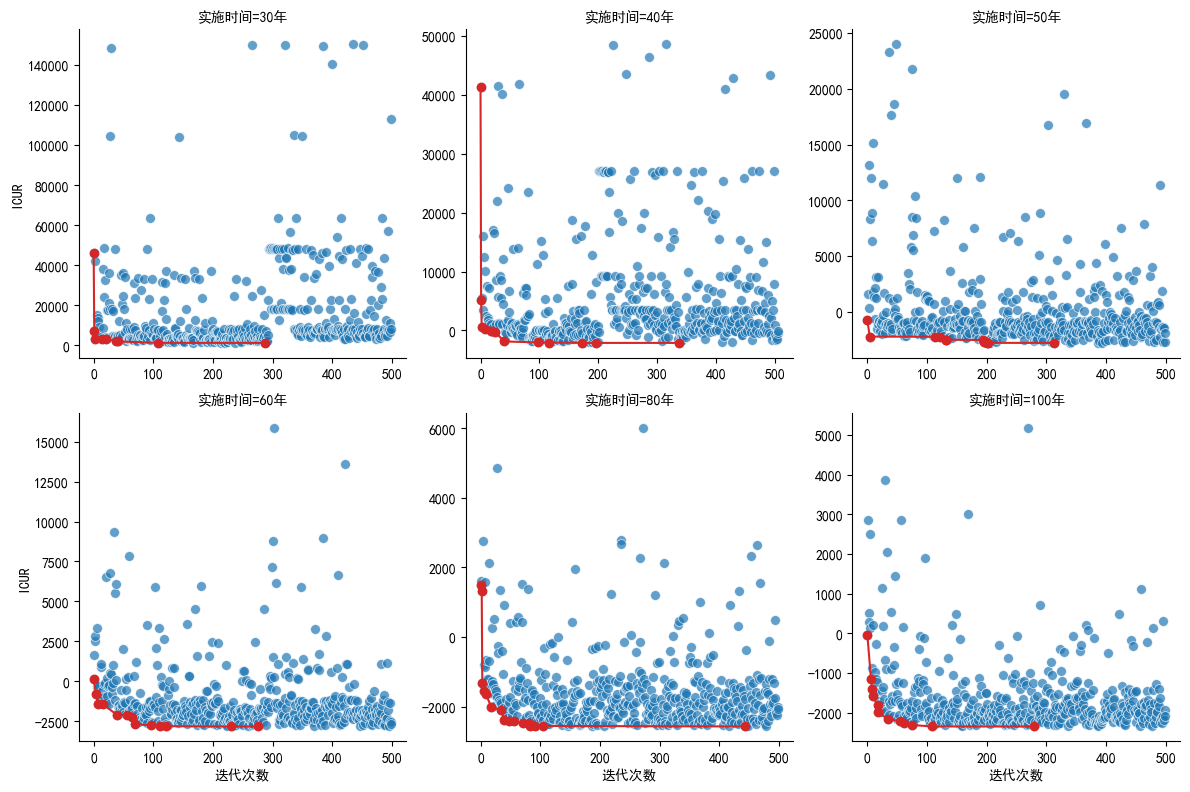

In [55]:
cmap = sns.color_palette()
fg = sns.relplot(data=df_hist, x="Trial", y="ICUR",
                 col="strategy", col_wrap=3, alpha=0.7, s=50,
                 facet_kws={"sharey": False, "sharex": False},
                 aspect=1.0, height=4)
fg.set_titles(col_template="实施时间={col_name}年")
fg.set_xlabels("迭代次数")
for k, ax in fg.axes_dict.items():
    dfi = df_hist.query("strategy == '%s'" % k)
    dfi = dfi.loc[dfi["is_best"], :]
    ax.plot(
        dfi["Trial"].values,
        dfi["ICUR"].values,
        marker="o",
        color=cmap[3],
        alpha=1.0,
        label=None
    )
plt.show()

In [56]:
fg.savefig("./results/optim_hist.png")

## Figure(帕累托优化结果)

In [52]:
df_pareto = []
for k in d_results.keys():
    dfi = []
    for trial in d_trials[k]:
        value = {"Trial": trial.number,
                 "ICUR": trial.values[0],
                 "Incidence": trial.values[1]}
        dfi.append(value)
    dfi = pd.DataFrame.from_records(dfi)

    best_indice = []
    best_icer, bbest_ind = np.inf, None
    for trial in d_best_trials[k]:
        best_indice.append(trial.number)
        if trial.values[0] < best_icer and trial.values[1] <= 4e-5:
            best_icer = trial.values[0]
            bbest_ind = trial.number
    dfi["best"] = "试验"
    dfi.loc[dfi["Trial"].isin(best_indice), "best"] = "最优试验"
    # dfi.loc[dfi.Trial == bbest_ind, "best"] = "Choice"

    dfi["strategy"] = d_duration[k]
    df_pareto.append(dfi)
df_pareto = pd.concat(df_pareto)
df_pareto.head()

,Trial,ICUR,Incidence,best,strategy
0,0,46093.428473,0.000057,试验,30
1,1,7000.248076,0.000070,试验,30
2,2,41981.660986,0.000072,试验,30
3,3,3342.312739,0.000097,试验,30
4,4,5010.419952,0.000049,试验,30


/tmp/ipykernel_22211/1445533693.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  fg = sns.relplot(


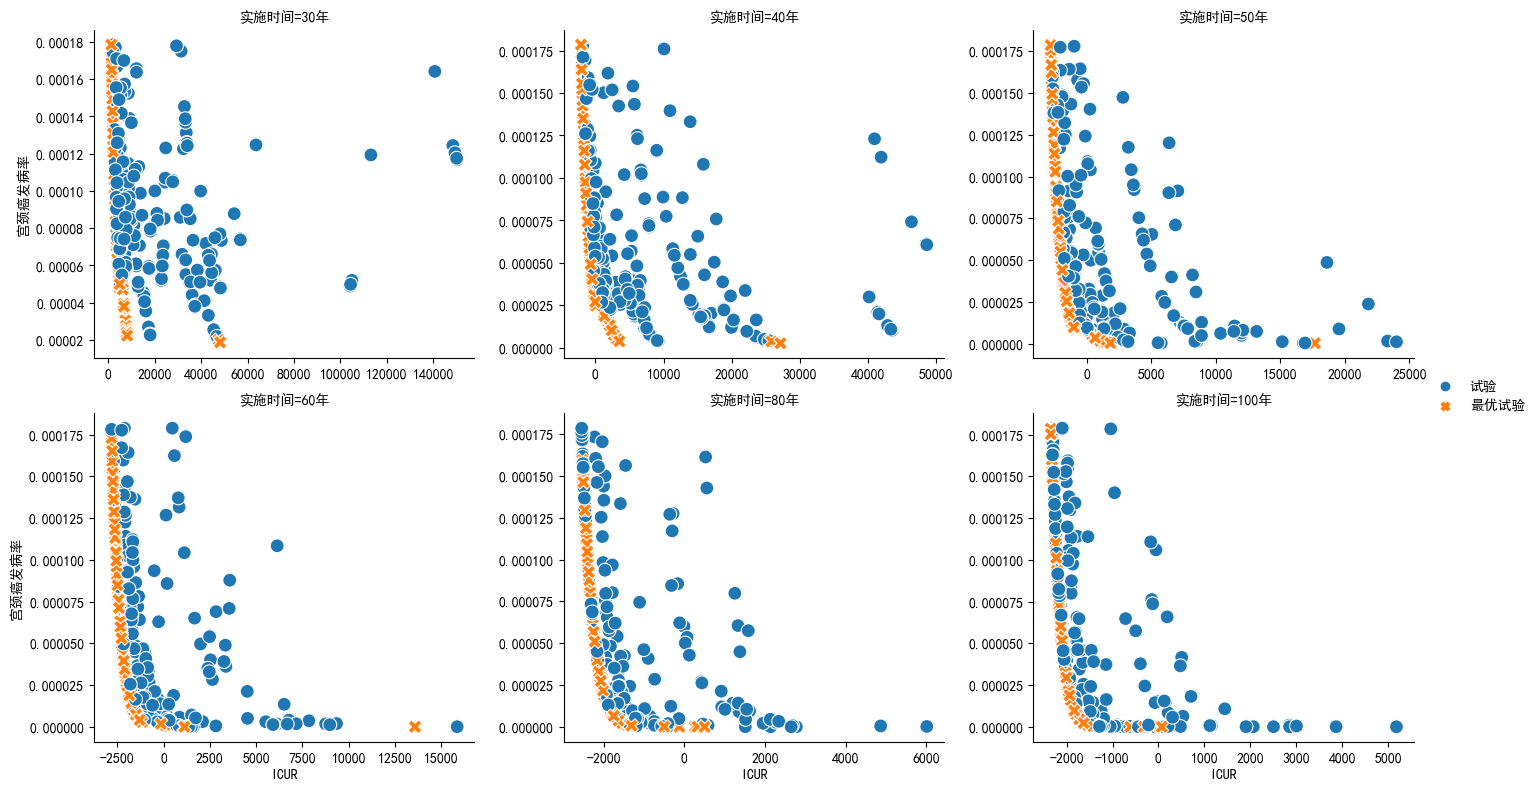

In [53]:
cmap = sns.color_palette()
fg = sns.relplot(
    data=df_pareto, x="ICUR", y="Incidence", hue="best", style="best",
     col="strategy", col_wrap=3, alpha=1.0,
     facet_kws={"sharey": False, "sharex": False},
     aspect=1.2, palette=[cmap[0], cmap[1], cmap[3]],
     s=100, height=4,
     # sizes={"Trial": 50, "Best Trial": 90, "Choice": 300}
)
fg.set_titles(col_template="实施时间={col_name}年")
fg.set_ylabels("宫颈癌发病率")
# fg.refline(y=0.00004)
fg._legend.set_title("")
plt.show()

In [54]:
fg.savefig("./results/pareto.png")

# 成本

## 计算成本

In [12]:
df_cost = []
for k, values in d_values.items():
    # if d_duration[k] != "40":
    #     continue
    t = values["t"]
    tar_cost_vacc = values["cost_vacc"]
    tar_cost_cecx = values["cost_cecx"]
    tar_ycum = values["ycum"]
    ref = values["ref"]
    
    nVacc = tar_ycum[:, -1].sum(axis=1)
    ref_cost_cecx = ref["cu"]["cost_cecx"]
    diff_cost_cecx = ref_cost_cecx - tar_cost_cecx
    net_cost = tar_cost_vacc - diff_cost_cecx
    # break

    dfi = pd.DataFrame({
        "t": t,
        "接种人数(万人)": nVacc / 10000,
        "疫苗成本(万元)": tar_cost_vacc / 10000,
        "节约治疗成本(万元)": diff_cost_cecx / 10000,
        "净节约成本(万元)": net_cost / 10000
    })
    dfi["strategy"] = k
    df_cost.append(dfi)
    
df_cost = pd.concat(df_cost)
df_cost.head()

,t,接种人数(万人),疫苗成本(万元),节约治疗成本(万元),净节约成本(万元),strategy
0,0.000000,0.000000,0.000000,0.000000,0.000000,策略1
1,0.303030,225.130332,34489.966875,0.157240,34489.809635,策略1
2,0.606061,432.026709,66186.491877,2.338412,66184.153465,策略1
3,0.909091,623.937308,95587.195576,11.028837,95576.166739,策略1
4,1.212121,803.531433,123101.015476,32.546648,123068.468827,策略1


## Table

In [13]:
df_cost_table = df_cost.groupby("strategy").apply(lambda df: df.sort_values("t").iloc[-1])
df_cost_table.round(2)

99,t,接种人数(万人),疫苗成本(万元),节约治疗成本(万元),净节约成本(万元),strategy
strategy,,,,,,
策略1,30.0,12743.26,1952267.16,932739.11,1019528.05,策略1
策略2,40.0,11124.07,1136138.73,1227696.06,-91557.33,策略2
策略3,50.0,9155.22,935052.81,1603751.40,-668698.59,策略3
策略4,60.0,8562.54,874521.12,2054576.04,-1180054.92,策略4
策略5,80.0,8399.62,857880.91,3047153.18,-2189272.26,策略5
策略6,100.0,8747.84,893446.40,3977563.81,-3084117.40,策略6


## Figure

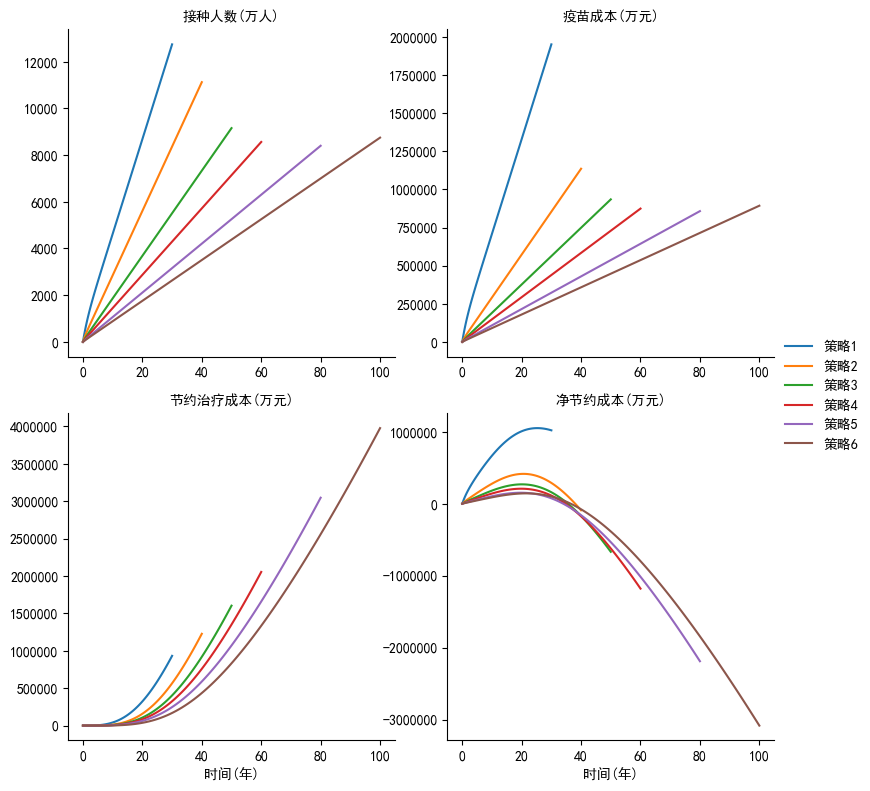

In [14]:
df_cost_long = df_cost.melt(id_vars=["t", "strategy"], var_name="var", value_name="value")
fg = sns.relplot(data=df_cost_long, x="t", y="value", hue="strategy",
                 col="var", col_wrap=2,
                 facet_kws={"sharey": False, "sharex": False},
                 aspect=1.0, kind="line", height=4)
fg.set_titles(col_template="{col_name}")
fg.set_xlabels("时间(年)")
fg.set_ylabels("")
# fg.refline(y=4e-5)
fg._legend.set_title("")
for ax in fg.axes:
    ax.ticklabel_format(style='plain', axis='y',)
plt.show()

In [15]:
fg.savefig("./results/cost.png")

# 发病率

## 计算发病率

In [16]:
df_inci = []
for k, values in d_values.items():
    dfi = pd.DataFrame({"t": values["t"], "inci": values["inci"]})
    dfi["strategy"] = k
    df_inci.append(dfi)
    if d_duration[k] == "100":
        ref = values["ref"]
        inci = ref["inci"]
        t = ref["t"]
        dfi = pd.DataFrame({"t": t, "inci": inci})
        dfi["strategy"] = "无疫苗接种"
        df_inci.append(dfi)

df_inci = pd.concat(df_inci, axis=0)
df_inci["strategy"] = pd.Categorical(df_inci["strategy"], categories=["无疫苗接种"] + list(d_values.keys()))
df_inci.head()

,t,inci,strategy
0,0.000000,0.000179,策略1
1,0.303030,0.000179,策略1
2,0.606061,0.000179,策略1
3,0.909091,0.000179,策略1
4,1.212121,0.000179,策略1


In [17]:
# 年龄组发病率
df_inci_ages = []
for k, values in d_values.items():
    t = values["t"]
    y = values["y"]
    model = values["model"]

    # 瞬时发病率
    Pf = y[:, 2]
    DeltaLC = model.beta_P * Pf
    inci = DeltaLC / y[:, :model.nrooms_f].sum(axis=1)
    
    dfi = pd.DataFrame({
        "t": np.repeat(t, inci.shape[1]),
        "age": pd.Categorical(np.tile(model.agebin_names, inci.shape[0]), categories=model.agebin_names, ordered=True),
        "inci": inci.flatten()
    })
    dfi["strategy"] = k
    df_inci_ages.append(dfi)
    
df_inci_ages = pd.concat(df_inci_ages)
print(df_inci_ages.shape)
df_inci_ages.head()

(15600, 4)


,t,age,inci,strategy
0,0.0,"[0, 1)",-3.574766e-124,策略1
1,0.0,"[1, 9)",5.092164e-125,策略1
2,0.0,"[9, 10)",-1.518665e-122,策略1
3,0.0,"[10, 11)",4.796535e-120,策略1
4,0.0,"[11, 12)",-1.440458e-117,策略1


## Figure(总体发病率)

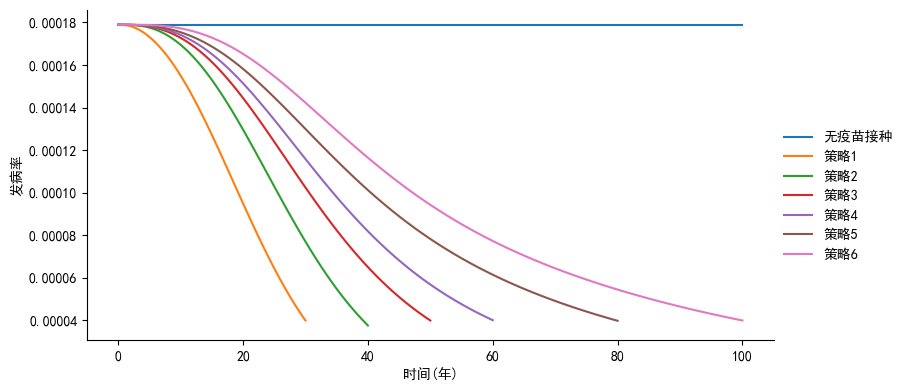

In [18]:
fg = sns.relplot(
    data=df_inci, x="t", y="inci", hue="strategy", kind="line",
    aspect=2, height=4
)
fg.set_xlabels("时间(年)")
fg.set_ylabels("发病率")
fg._legend.set_title("")
plt.show()

In [19]:
fg.savefig("./results/incidence.png")

## Figure(年龄组发病率)

In [20]:
df_inci_ages_last = df_inci_ages.groupby(["strategy", "age"]).apply(lambda df: df.sort_values("t").iloc[-1])
df_inci_ages_last.head()

t       age           inci strategy
strategy age                                             
策略1      [0, 1)    30.0    [0, 1) -8.735240e-142      策略1
         [1, 9)    30.0    [1, 9)  1.244333e-142      策略1
         [9, 10)   30.0   [9, 10) -3.710934e-140      策略1
         [10, 11)  30.0  [10, 11)  1.171884e-137      策略1
         [11, 12)  30.0  [11, 12) -3.518072e-135      策略1

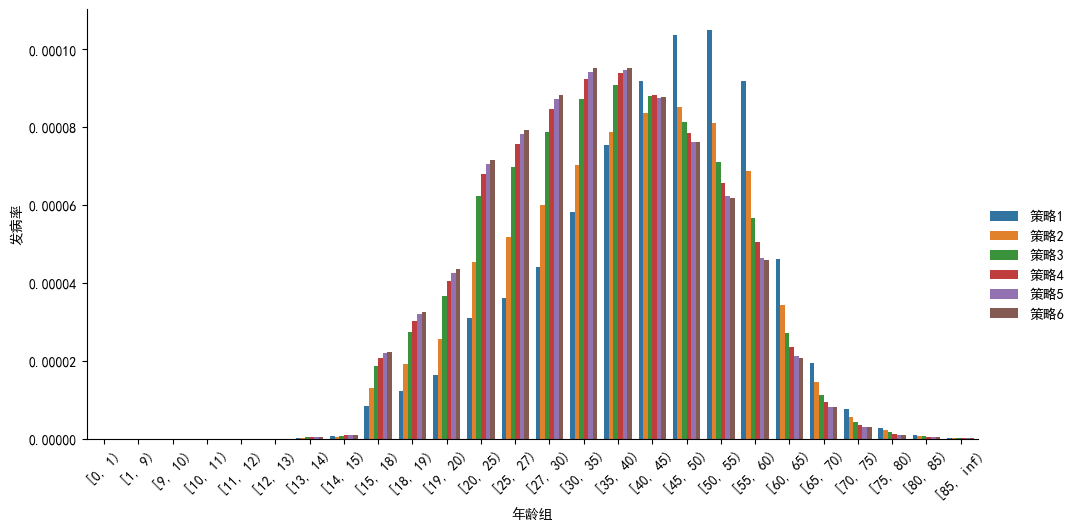

In [21]:
fg = sns.catplot(
    data=df_inci_ages_last, x="age", y="inci", hue="strategy", kind="bar",
    aspect=2
)
# sns.lineplot(data=df_inci_ages_last, x="age", y="inci", hue="strategy", ax=fg.ax)
fg.set_xlabels("年龄组")
fg.set_ylabels("发病率")
fg.set_xticklabels(rotation=45)
fg._legend.set_title("")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [22]:
fg.savefig("./results/incidence_age.png")

## Figure(随时间变化的年龄组发病率)

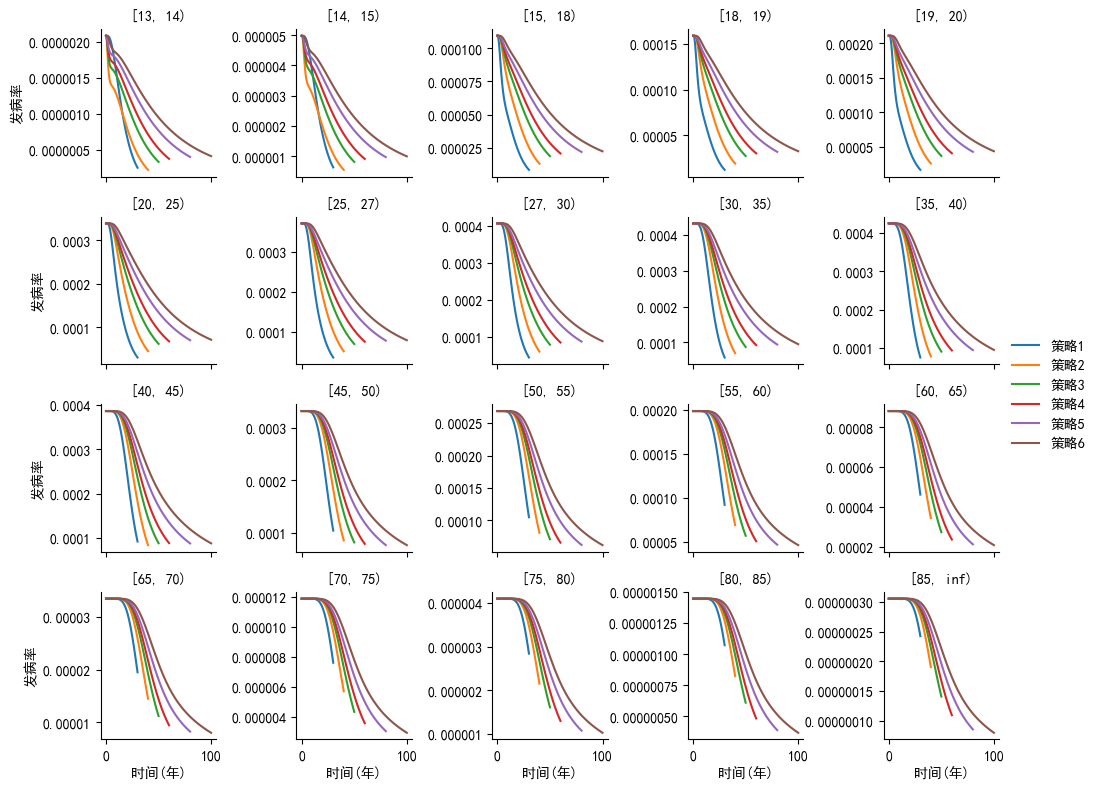

In [23]:
df_plot = df_inci_ages[df_inci_ages.age > "[12, 13)"].copy()
df_plot["age"] = df_plot.age.cat.remove_unused_categories()
fg = sns.relplot(
    data=df_plot, x="t", y="inci", hue="strategy", col="age",
    col_wrap=5, height=2, kind="line", facet_kws={"sharey": False}
)
fg.set_titles(col_template="{col_name}")
fg.set_ylabels("发病率")
fg.set_xlabels("时间(年)")
fg._legend.set_title("")
for ax in fg.axes:
    ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [24]:
fg.savefig("./results/incidence_age_time.png")

# 宫颈癌死亡率

## 计算死亡率

In [25]:
# 当时间间隔不同时，会计算错误
# def calculate_t_deathp(t, y, ycum):
#     deathi = ycum[:, 6:9].sum(axis=(1, 2))
#     deathi = deathi[1:] - deathi[:-1]
#     popu = y[:, :values["model"].nrooms_f].sum(axis=(1, 2))
#     popu = (popu[1:] + popu[:-1]) / 2
#     deathp = deathi / popu
#     # return (t[1:] + t[:-1]) / 2, deathp
#     return t[1:], deathp

# 瞬时死亡率
def calculate_t_deathp_instant(t, y, model, total=True):
    LC, RC, DC = y[:, 3], y[:, 4], y[:, 5]
    deathi = model.dL * LC + model.dR * RC + model.dD *DC
    popu = y[:, :values["model"].nrooms_f].sum(axis=(1, 2))
    if total:
        deathp = deathi.sum(axis=1) / popu
    else:
        deathp = deathi / popu[:, None]
    return t, deathp

In [26]:
df_death = []
for k, values in d_values.items():
    t = values["t"]
    y = values["y"]
    # ycum = values["ycum"]
    model = values["model"]
    
    t, deathp = calculate_t_deathp_instant(t, y, model)
    dfi = pd.DataFrame({"t": t, "deathp": deathp})
    dfi["strategy"] = k
    df_death.append(dfi)

    if d_duration[k] == "100":
        ref = values["ref"]
        t, deathp = calculate_t_deathp_instant(ref["t"], ref["y"], ref["model"])
        dfi = pd.DataFrame({"t": t, "deathp": deathp})
        dfi["strategy"] = "无疫苗接种"
        df_death.append(dfi)

df_death = pd.concat(df_death, axis=0)
df_death["strategy"] = pd.Categorical(df_death["strategy"], categories=["无疫苗接种"] + list(d_values.keys()))
df_death.head()

,t,deathp,strategy
0,0.000000,0.000034,策略1
1,0.303030,0.000034,策略1
2,0.606061,0.000034,策略1
3,0.909091,0.000034,策略1
4,1.212121,0.000034,策略1


In [27]:
# 年龄组死亡率
df_death_ages = []
for k, values in d_values.items():
    t = values["t"]
    y = values["y"]
    # ycum = values["ycum"]
    model = values["model"]

    t, deathp = calculate_t_deathp_instant(t, y, model, total=False)
    
    dfi = pd.DataFrame({
        "t": np.repeat(t, deathp.shape[1]),
        "age": pd.Categorical(np.tile(model.agebin_names, t.shape[0]), categories=model.agebin_names, ordered=True),
        "deathp": deathp.flatten()
    })
    dfi["strategy"] = k
    df_death_ages.append(dfi)
    
df_death_ages = pd.concat(df_death_ages)
print(df_death_ages.shape)
df_death_ages.head()

(15600, 4)


,t,age,deathp,strategy
0,0.0,"[0, 1)",0.0,策略1
1,0.0,"[1, 9)",0.0,策略1
2,0.0,"[9, 10)",0.0,策略1
3,0.0,"[10, 11)",0.0,策略1
4,0.0,"[11, 12)",0.0,策略1


## Figure(总体死亡率)

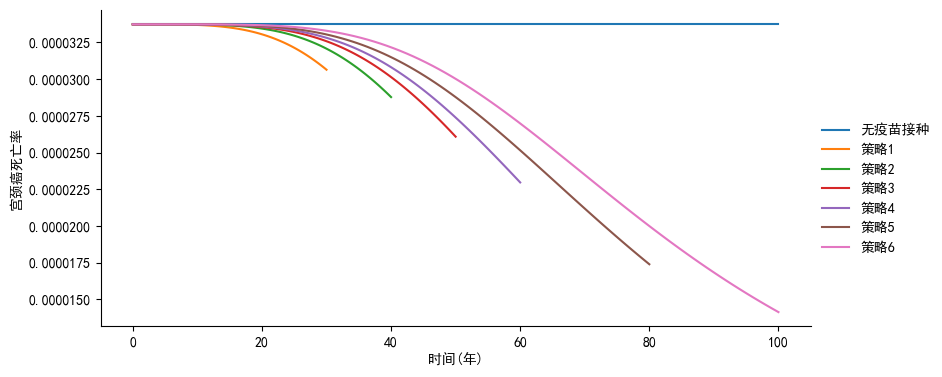

In [28]:
fg = sns.relplot(
    data=df_death, x="t", y="deathp", hue="strategy", kind="line",
    aspect=2, height=4
)
fg.set_xlabels("时间(年)")
fg.set_ylabels("宫颈癌死亡率")
fg._legend.set_title("")
fg.ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [29]:
fg.savefig("./results/deathp.png")

## Figure(年龄组发病率)

In [30]:
df_death_ages_last = df_death_ages.groupby(["strategy", "age"]).apply(lambda df: df.sort_values("t").iloc[-1])
df_death_ages_last.head()

t       age  deathp strategy
strategy age                                      
策略1      [0, 1)    30.0    [0, 1)     0.0      策略1
         [1, 9)    30.0    [1, 9)     0.0      策略1
         [9, 10)   30.0   [9, 10)     0.0      策略1
         [10, 11)  30.0  [10, 11)     0.0      策略1
         [11, 12)  30.0  [11, 12)     0.0      策略1

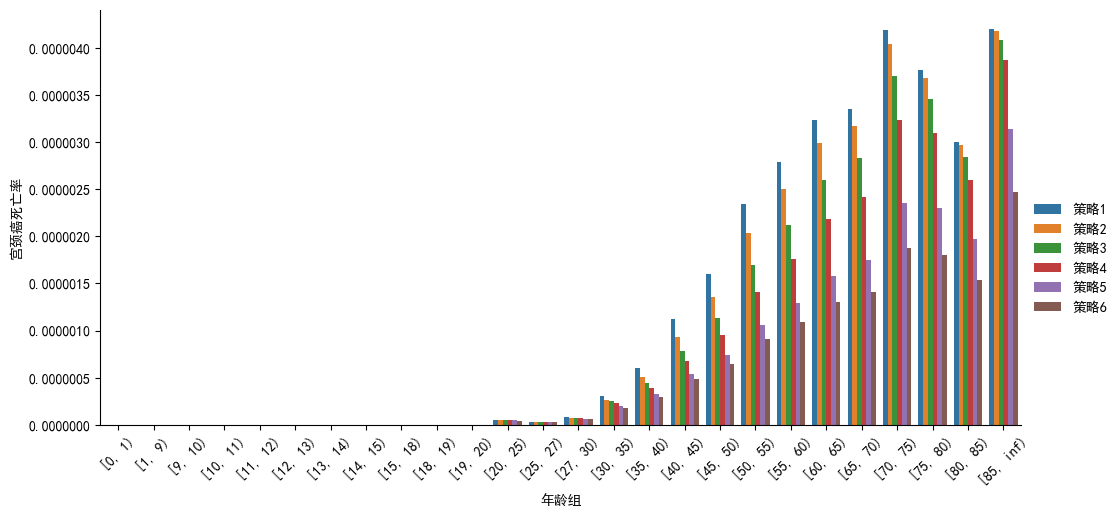

In [31]:
fg = sns.catplot(
    data=df_death_ages_last, x="age", y="deathp", hue="strategy", kind="bar",
    aspect=2
)
# sns.lineplot(data=df_inci_ages_last, x="age", y="inci", hue="strategy", ax=fg.ax)
fg.set_xlabels("年龄组")
fg.set_ylabels("宫颈癌死亡率")
fg.set_xticklabels(rotation=45)
fg._legend.set_title("")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [32]:
fg.savefig("./results/deathp_age.png")

## Figure(随时间变化的年龄组发病率)

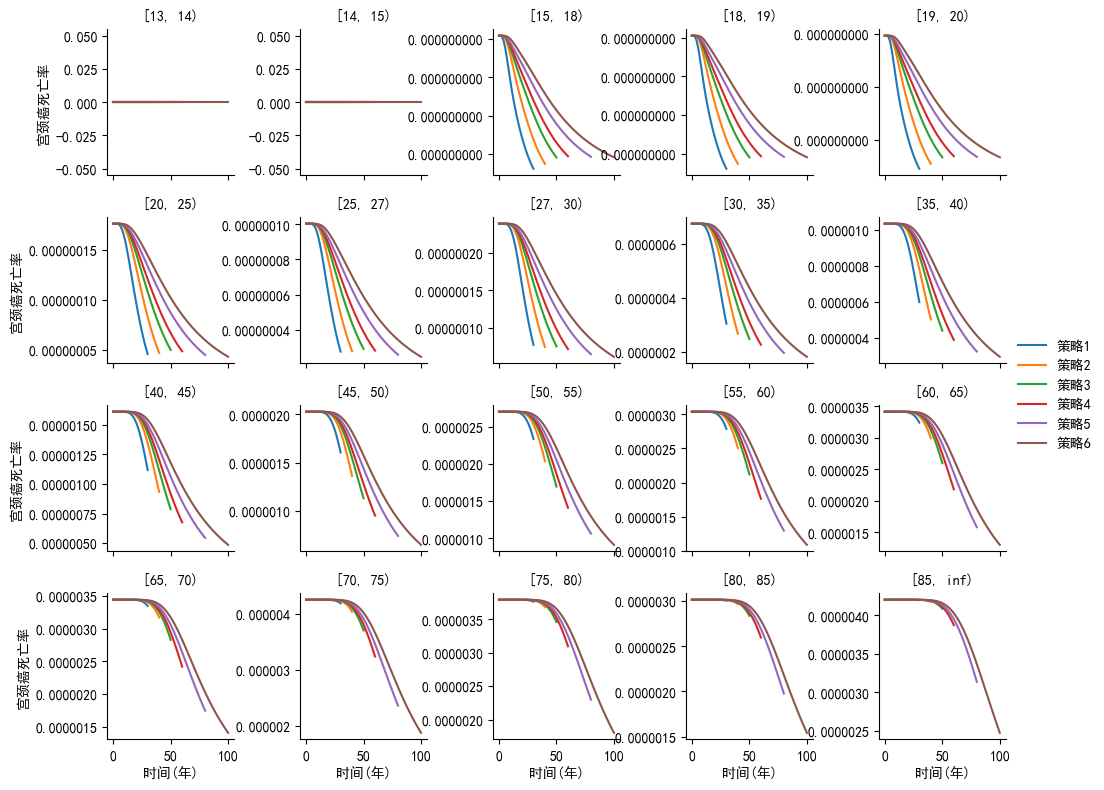

In [33]:
df_plot = df_death_ages[df_death_ages.age > "[12, 13)"].copy()
df_plot["age"] = df_plot.age.cat.remove_unused_categories()
fg = sns.relplot(
    data=df_plot, x="t", y="deathp", hue="strategy", col="age",
    col_wrap=5, height=2, kind="line", facet_kws={"sharey": False}
)
fg.set_titles(col_template="{col_name}")
fg.set_ylabels("宫颈癌死亡率")
fg.set_xlabels("时间(年)")
for ax in fg.axes:
    ax.ticklabel_format(style='plain', axis='y')
fg._legend.set_title("")
plt.show()

In [34]:
fg.savefig("./results/deathp_age_time.png")

# 增量效果成本比

## 计算各项增量效果成本比

In [35]:
df_ICUR = []
for k, values in d_values.items():
    t = values["t"]
    ref = values["ref"]
    tar_cost_cecx = values["cost_cecx"]
    tar_cost_vacc = values["cost_vacc"]
    avoid_inci = values["avoid_inci"]
    avoid_death = values["avoid_death"]
   
    ref_cost_cecx = ref["cu"]["cost_cecx"]
    diff_cost_cecx = ref_cost_cecx - tar_cost_cecx
    net_cost = tar_cost_vacc - diff_cost_cecx
    # avoid_inci = np.load(osp.join(tar_root, "avoid_inci.npy"))
    # avoid_death = np.load(osp.join(tar_root, "avoid_death.npy"))
    avoid_inci = avoid_inci.sum(axis=-1)
    avoid_death = avoid_death.sum(axis=(1, 2))
    tar_daly = values["DALY_nd"] + values["DALY_d"] + values["lifeloss"]
    ref_daly = ref["cu"]["DALY_nodeath"] + ref["cu"]["DALY_death"] +\
        ref["cu"]["LifeLoss"]
    avoid_daly = ref_daly - tar_daly

    dfi = pd.DataFrame({
        "t": t,
        "避免发病（万人）": avoid_inci / 10000,
        "避免死亡（万人）": avoid_death / 10000,
        "挽救的DALY（万）": avoid_daly / 10000,
        "每避免一例发病的成本": net_cost / avoid_inci,
        "每避免一例死亡的成本": net_cost / avoid_death,
        "增量成本效用比(ICUR)": net_cost / avoid_daly,
    })
    dfi["strategy"] = k
    df_ICUR.append(dfi)

df_ICUR = pd.concat(df_ICUR)
df_ICUR.head()

/tmp/ipykernel_22211/2407471756.py:27: RuntimeWarning: invalid value encountered in true_divide
  "每避免一例发病的成本": net_cost / avoid_inci,
/tmp/ipykernel_22211/2407471756.py:28: RuntimeWarning: invalid value encountered in true_divide
  "每避免一例死亡的成本": net_cost / avoid_death,
/tmp/ipykernel_22211/2407471756.py:29: RuntimeWarning: invalid value encountered in true_divide
  "增量成本效用比(ICUR)": net_cost / avoid_daly,
/tmp/ipykernel_22211/2407471756.py:27: RuntimeWarning: invalid value encountered in true_divide
  "每避免一例发病的成本": net_cost / avoid_inci,
/tmp/ipykernel_22211/2407471756.py:28: RuntimeWarning: invalid value encountered in true_divide
  "每避免一例死亡的成本": net_cost / avoid_death,
/tmp/ipykernel_22211/2407471756.py:29: RuntimeWarning: invalid value encountered in true_divide
  "增量成本效用比(ICUR)": net_cost / avoid_daly,
/tmp/ipykernel_22211/2407471756.py:27: RuntimeWarning: invalid value encountered in true_divide
  "每避免一例发病的成本": net_cost / avoid_inci,
/tmp/ipykernel_22211/2407471756.py:28: RuntimeW

,t,避免发病（万人）,避免死亡（万人）,挽救的DALY（万）,每避免一例发病的成本,每避免一例死亡的成本,增量成本效用比(ICUR),strategy
0,0.000000,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,策略1
1,0.303030,0.000021,9.876459e-11,0.000016,1.655401e+09,3.492123e+14,2.177276e+09,策略1
2,0.606061,0.000310,3.228158e-09,0.000236,2.136030e+08,2.050214e+13,2.808072e+08,策略1
3,0.909091,0.001461,2.512781e-08,0.001112,6.540248e+07,3.803601e+12,8.593034e+07,策略1
4,1.212121,0.004313,1.085858e-07,0.003285,2.853743e+07,1.133376e+12,3.746937e+07,策略1


## Table

In [36]:
df_table = df_ICUR.groupby("strategy").apply(lambda df: df.sort_values("t").iloc[-1])
df_table.round(2)

99,t,避免发病（万人）,避免死亡（万人）,挽救的DALY（万）,每避免一例发病的成本,每避免一例死亡的成本,增量成本效用比(ICUR),strategy
strategy,,,,,,,,
策略1,30.0,123.59,1.40,153.74,8249.23,729183.37,6631.37,策略1
策略2,40.0,162.67,2.90,235.54,-562.83,-31581.47,-388.71,策略2
策略3,50.0,212.50,5.96,366.26,-3146.79,-112288.04,-1825.73,策略3
策略4,60.0,272.24,10.90,546.15,-4334.65,-108225.75,-2160.68,策略4
策略5,80.0,403.76,26.30,1011.80,-5422.25,-83238.88,-2163.74,策略5
策略6,100.0,527.04,44.78,1501.49,-5851.78,-68866.16,-2054.04,策略6


## Figure

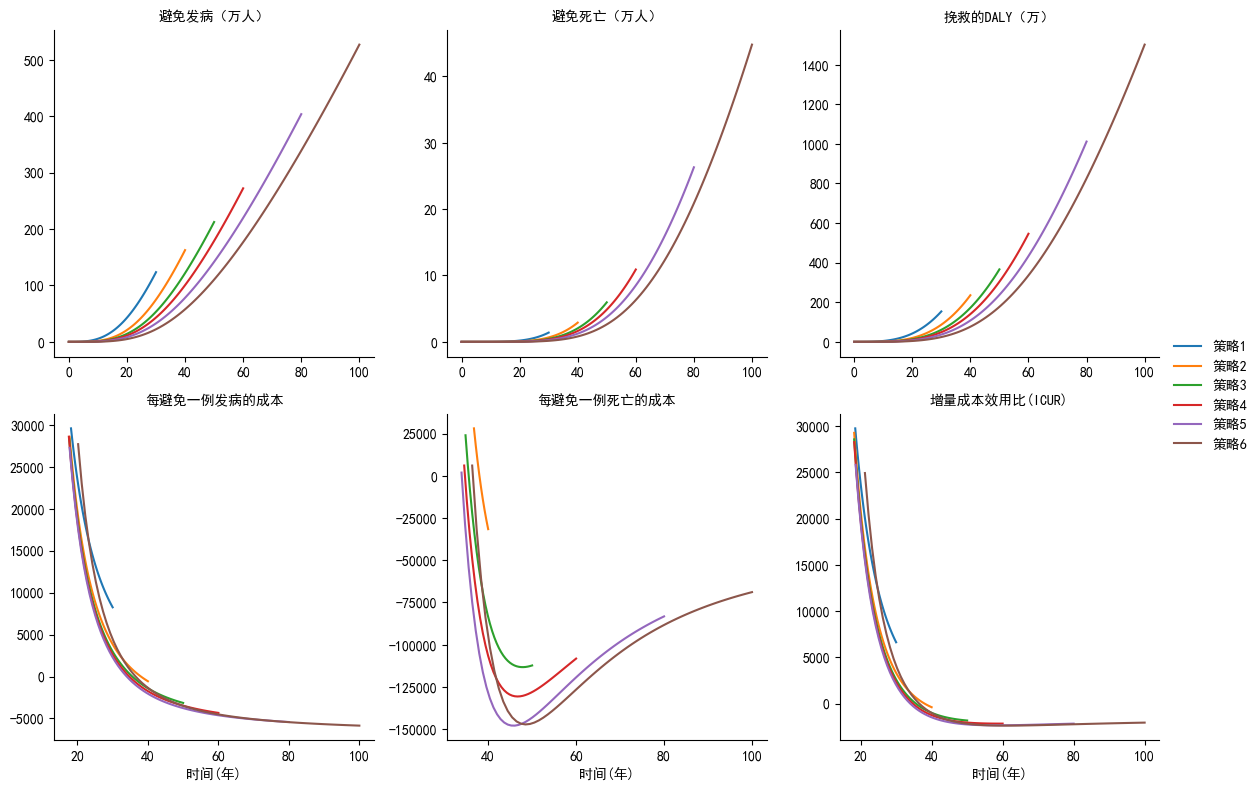

In [37]:
df_ICUR_long = df_ICUR.melt(id_vars=["t", "strategy"], var_name="var", value_name="value")
df_ICUR_long = df_ICUR_long.query("value < 30000")
fg = sns.relplot(
    data=df_ICUR_long, x="t", y="value", hue="strategy",
    col="var", col_wrap=3,
    facet_kws={"sharey": False,"sharex": False},
    aspect=1.0, kind="line", height=4,
)
fg.set_titles(col_template="{col_name}")
fg.set_xlabels("时间(年)")
fg.set_ylabels("")
# fg.refline(y=4e-5)
fg._legend.set_title("")
plt.show()

In [38]:
fg.savefig("./results/avoid.png")

# 每年发病和死亡人数

In [39]:
df_number = []
for k, values in d_values.items():
    if d_duration[k] == "40":
        model = values["model"]
        ref = values["ref"]
        init = np.r_[ref["y"][0].flatten(), np.zeros(np.prod(ref["ycum"].shape[1:]))]
        t_span = (ref["t"].min(),ref["t"].max())
        t_eval = np.linspace(*t_span, int(t_span[1]+1))
        res = model.predict(init=init, t_span=t_span, t_eval=t_eval, verbose=False)
        t = res["t"]
        ycum = res["ycum"]

        inci_n = ycum[:, 3].sum(axis=1)
        death_n = ycum[:, 6:9].sum(axis=(1, 2))

        df_number.append(pd.DataFrame({"t": t, "发病人数": inci_n, "死亡人数": death_n}))

    # # 得到reference的发病人数和死亡人数
    # if d_duration[k] == "100":
        ref = values["ref"]
        model = ref["model"]
        
        init = np.r_[ref["y"][0].flatten(), np.zeros(np.prod(ref["ycum"].shape[1:]))]
        t_span = (0, 40)
        t_eval = np.linspace(0, 40, 41)
        res = model.predict(init=init, t_span=t_span, t_eval=t_eval, verbose=False)
        t = res["t"]
        ycum = res["ycum"]
        inci_n = ycum[:, 3].sum(axis=1)
        death_n = ycum[:, 6:9].sum(axis=(1, 2))
        df_number.append(pd.DataFrame({"原发病人数": inci_n, "原死亡人数": death_n}))
        
df_number = pd.concat(df_number, axis=1)
df_number.head()

,t,发病人数,死亡人数,原发病人数,原死亡人数
0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,127202.661165,23988.650842,127203.580781,23988.650847
2,2.0,254387.389984,47977.249746,254406.889425,47977.250314
3,3.0,381489.321025,71965.790474,381609.925915,71965.798404
4,4.0,508383.674208,95954.245434,508812.690305,95954.295117


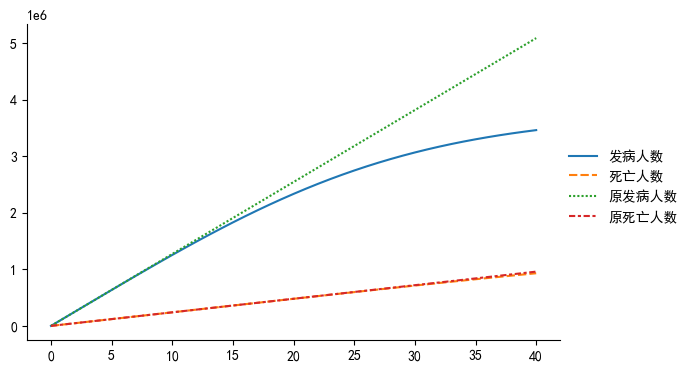

In [40]:
sns.relplot(df_number.set_index(t).drop(columns="t"), kind="line", height=4, aspect=1.5)
plt.show()

In [42]:
df_number

,t,发病人数,死亡人数,原发病人数,原死亡人数
0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000
1,1.0,1.272027e+05,23988.650842,1.272036e+05,23988.650847
2,2.0,2.543874e+05,47977.249746,2.544069e+05,47977.250314
3,3.0,3.814893e+05,71965.790474,3.816099e+05,71965.798404
4,4.0,5.083837e+05,95954.245434,5.088127e+05,95954.295117
5,5.0,6.348990e+05,119942.538501,6.360152e+05,119942.740458
6,6.0,7.608344e+05,143930.508303,7.632174e+05,143931.134425
7,7.0,8.859716e+05,167917.864638,8.904194e+05,167919.477024
8,8.0,1.010081e+06,191904.140661,1.017621e+06,191907.768254
9,9.0,1.132926e+06,215888.642933,1.144822e+06,215896.008119


In [43]:
df_number.to_excel("./results/发病人数和死亡人数.xlsx")